## Goes through the job_url_data csv's and saves each url, alongside the date of the csv file, into a dictionary. If a url reappears in a csv file corresponding to a  later date, it is not saved, maintaining the earliest date. The dictionary is then printed to a json file.

In [1]:
import os
import csv
from datetime import datetime
import json

path_url = './indeed_scraped_data/job_url_data'
path_info = './indeed_scraped_data/job_info_data'

urls = []
url_dict = {}
for i in os.listdir(path=path_url):
    if i.endswith("csv"):
        with open(os.path.join(path_url, i)) as f:
            date = i.split('_')[-2]
            date = date[:1] + '-' + date[1:3] + '-' + date[3:]
            head = next(f)
            csvf = csv.reader(f)
            for row in csvf:
                if row[0] not in url_dict:
                    url_dict.update({row[0]:date})

with open('job_url_data.json','w') as f:
    csv_json = json.dump(url_dict, f)
len(url_dict)


21260

### 21,260 unique listings

## The csv and json files in the job_info_data folder are read into a single dataframe. Column names are adjusted for consistency. Rows with missing job titles and/or descriptions are dropped, then rows with duplicate urls are dropped, keeping the first instance. The duplicate urls are saved to one csv, the cleaned dataframe is saved to another.

In [2]:
import pandas as pd

df = pd.DataFrame()
for count, i in enumerate(os.listdir(path=path_info)):
    if i.endswith("csv"):
        if count == 1:
            df = pd.read_csv(os.path.join(path_info, i))
            df = df.rename(columns={'lnks_link':'link',
                                   'lnks_job_title':'job_title',
                                    'lnks_company':'company',
                                    'lnks_company_url':'company_url',
                                    'lnks_company_location':'company_location',
                                    'lnks_job_description':'job_description'
                                   })
        else:
            df_temp = pd.read_csv(os.path.join(path_info, i))
            df_temp = df_temp.rename(columns={'lnks_link':'link',
                                   'lnks_job_title':'job_title',
                                    'lnks_company':'company',
                                    'lnks_company_url':'company_url',
                                    'lnks_company_location':'company_location',
                                    'lnks_job_description':'job_description'
                                   })
            df = pd.concat([df, df_temp])
        
            
    elif i.endswith('json'):
        if count == 1:
            with open(os.path.join(path_info, i), encoding='utf8') as f:
                json_obj = json.load(f)
                df =  pd.DataFrame.from_dict(json_obj['lnks'])
        else:
            with open(os.path.join(path_info, i), encoding='utf8') as f:
                json_obj = json.load(f)
                df_temp = pd.DataFrame.from_dict(json_obj['lnks'])
                df = pd.concat([df, df_temp])
                
df.dropna(subset=['job_title','job_description'], inplace=True)

dup_df = df.loc[df.duplicated(subset=['link']), :]
df.drop_duplicates(subset=['link'], keep='first', inplace=True)

dup_df.to_csv('duplicate_indeed_info.csv')
df.to_csv('indeed_info.csv')

print(F"The amount of duplicate entries are {len(dup_df)}.\nThe amount of unique entries are {len(df)}")

The amount of duplicate entries are 5207.
The amount of unique entries are 16303


### The amount of unique entries are 16303

## The info dataframe and the url dictionary are merged together after the url dictionary is turned into a a dataframe. A series of histograms show the number of matched url's and unmatched url's per day.

both          16303
left_only      4957
right_only        0
Name: _merge, dtype: int64
date       _merge    
5-17-2022  both          3905
           left_only     1352
           right_only       0
5-18-2022  both          1324
           left_only        1
           right_only       0
5-19-2022  both          3790
           left_only        8
           right_only       0
5-20-2022  both          4503
           left_only       20
           right_only       0
5-21-2022  both          2113
           left_only       41
           right_only       0
5-22-2022  both           668
           left_only      112
           right_only       0
5-23-2022  left_only     3423
           right_only       0
           both             0
Name: _merge, dtype: int64


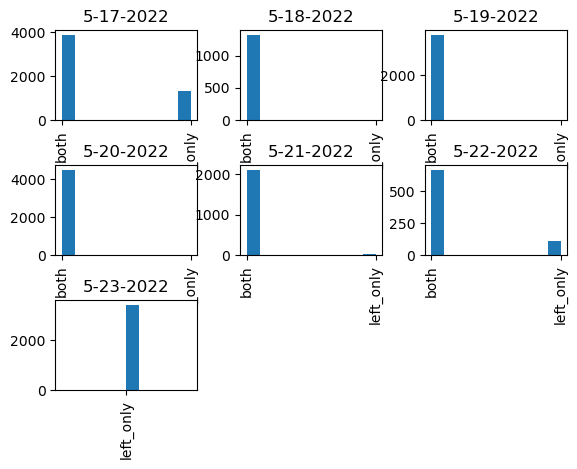

In [3]:
df_url = pd.DataFrame.from_dict(url_dict.items())
df_url.rename(columns={0:'link',1:'date'}, inplace=True)

merged_df = df_url.merge(df, how='left', indicator=True)
print(merged_df._merge.value_counts())
print(merged_df.groupby(['date'])._merge.value_counts())
merged_df._merge.hist(by=merged_df['date'])
merged_df.to_csv('merged_indeed.csv')

### In total, 16,303 entries are matched, but 4,957 are unmatched (i.e. 23% go unmatched). As we can see, a sizable number are unmatched on 5-17-2022, a small number on 5-22-2022, and all on 5-23-2022 are unmatched. Complete job listings collected per day ranged from the 600s to the 4500s. The high variation in percent matched per day suggests there are sampling biases within our data set.

## State information is extracted from the county location column. Two-letter state acronyms are then extracted from these columns, when said acronyms are provided. Using the states.geojson file, state acronyms and full state names are matched to the corresponding geometry in the geojson file. Afterwards, job listings are grouped by state and shown on a choropleth map using folium.

In [4]:
import math
import geopandas as gpd
import numpy as np
import folium

mdf = pd.read_csv('merged_indeed.csv')

for count in range(len(mdf)):
    if not pd.isna(mdf.loc[count, 'company_location']):
        if ', ' in mdf.loc[count, 'company_location']:
            mdf.loc[count, 'state'] = mdf.loc[count, 'company_location'].split(', ')[1].split(' ')[0]
        else:
            mdf.loc[count, 'state'] = mdf.loc[count, 'company_location']

geostates = gpd.read_file("states.geojson")
geostates['Jobs'] = 0
mdf['state'].unique()

for row, state in enumerate(geostates['NAME']):
    
    # have to look for states entries, listed as 2-character abbreviations or with full state names
    jobcount = (mdf[mdf['state'].apply(lambda x: len(str(x))>2)]['state'].str.find(state) == 0).sum()
    jobcount += (mdf[mdf['state'].apply(lambda x:len(str(x))<=2)]['state'].str.find(geostates.loc[row, 'STUSPS']) == 0).sum()
    geostates.loc[:,"Jobs"].iloc[row] = jobcount
    
clon, clat = -99.8283, 8.5795
m = folium.Map(location=(clat, clon), zoom_start=3, width=800, height=800)

geoloc = gpd.GeoSeries(geostates.set_index('NAME')['geometry']).to_json()

folium.Choropleth(
    geo_data = geoloc,
    name = 'Choropleth',
    data = geostates,
    columns = ['NAME','Jobs'],
    key_on = 'feature.id',
    fill_color = 'YlGnBu',
    fill_opacity = 0.5,
    line_opacity = 1,
    legend_name = 'Job Listings on Indeed (5-17-2022 to 5-23-2022)',
    smooth_factor=  0
).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
hover = folium.features.GeoJson(
    geostates,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME','Jobs'],
        aliases=['State: ','Job listings on Indeed: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 16px; padding: 10px;") 
    )
)
m.add_child(hover)
m.keep_in_front(hover)
folium.LayerControl().add_to(m)

display(m)


C:\Users\sain4\AppData\Local\Temp\ipykernel_24436\539700774.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geostates.loc[:,"Jobs"].iloc[row] = jobcount


### We find that states like Texas and California lead the curve, with over 1000 job listings over this time interval, and are followed by certain states on the East Coast, like New York and Florida. Other states, like Wyoming and Hawaii, only have tens of job listings over this period.